## This model version is used to train data from a glyphosate using data from the Hammamatsu spec sensor.
### Input data = 100 bands (50 from the dispersion spectrum + 50 from the emission spectrum)
### Number of samples at this point is 63 (in the range 0 to 1000 ppm) per group. Three groups of samples were obtained 1 on 10-17-25, and 2 on 10-18-25.

In [1]:
# Import modules
import os

# --- Step 1: Force CPU Usage (MUST be first) ---
# This ensures deterministic computations by avoiding the MPS GPU backend.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import random

# --- Step 2: Set All Random Seeds ---
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print("Forcing CPU-only execution for reproducibility. ✅")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler
# from tensorflow.keras.callbacks import EarlyStopping

import csv
# Misc
# from itertools import islice
# import plotly.express as px

Forcing CPU-only execution for reproducibility. ✅
Num GPUs Available:  0


## Inference functions


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

def apply_snv(X):
    """
    Aplica Standard Normal Variate (SNV) a un conjunto de espectros X.
    X debe tener la forma (n_muestras, n_bandas)
    """
    # Calcular media y std para cada muestra (fila)
    X_mean = np.mean(X, axis=1, keepdims=True)
    X_std = np.std(X, axis=1, keepdims=True)
    
    # Evitar división por cero si un espectro es plano
    X_std[X_std == 0] = 1.0
    
    # Aplicar SNV
    X_snv = (X - X_mean) / X_std
    return X_snv


def get_metrics(y_test,y_pred):
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    #r2 = r2_score(y_test, y_pred)
    regression_result = stats.linregress(y_test, y_pred)
    r2 = regression_result.rvalue ** 2

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R-squared (R2): {r2:.3f}")
    
    return(mae,rmse,r2)

def model_predict(dynamic_filename,X_test_scaled,y_test):
    # Load the saved model from the file
    print(f"Loading model from: {dynamic_filename}")
    loaded_model = tf.keras.models.load_model('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/Scripts/models/'+dynamic_filename)
    print("Model loaded successfully.")

    X_test = X_test_scaled
    # Use the loaded model to make predictions on the test data
    y_pred = loaded_model.predict(X_test)

    # The output of .predict() is often a 2D array, so we flatten it to a 1D array
    y_pred = y_pred.flatten()

    # LEGACY LOD & LOQ
    is_blank = (y_test <0.001)
    y_pred_blanks = y_pred[is_blank]
    print(y_pred_blanks)
    mu_blank = np.mean(y_pred_blanks)
  
    sigma_blank = np.std(y_pred_blanks) 
    print(mu_blank,sigma_blank)
    lod = mu_blank + (3 * sigma_blank)
    loq = mu_blank + (10 * sigma_blank)

    print(f"(LOD): {lod:.4f} ppm")
    print(f"(LOQ): {loq:.4f} ppm")

    #Residuals-based LOD/LOQ
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
    residuals = y_test - y_pred
    
    # SD of residuals (Sy/x)
    # ddof=1 for SSD
    std_resid = np.std(residuals, ddof=1)
    
    # ICH Q2(R1) formula for calibration method
    lod = 3.3 * (std_resid / slope)
    loq = 10.0 * (std_resid / slope)
    
    print(f"--- Residual Analysis ---")
    print(f"Slope: {slope:.4f}")
    print(f"Residual Std Dev: {std_resid:.4f}")
    print(f"(LOD): {lod:.4f} ppm")
    print(f"(LOQ): {loq:.4f} ppm")
    
    # --- FIN MODIFICACIÓN ---

    # Evaluation metrics
    mae,rmse,r2 = get_metrics(y_test,y_pred)
    
    # 2. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot of actual vs. predicted values
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", label='Predictions')

    # Add a line for perfect predictions (y=x)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

    # 3. Add metrics to the plot
    # Using LaTeX for R^2
    metrics_text = (
        f"$R^2$ = {r2:.3f}\n"
        f"MAE = {mae:.3f}\n"
        f"RMSE = {rmse:.3f}"
    )
    # Place text box in the top-left corner
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # 4. Final plot settings
    ax.set_xlabel("Actual Values (y_test)", fontsize=12)
    ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
    ax.set_title("Actual vs. Predicted Values", fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return loaded_model

### Read main file with samples

In [3]:
# Create augmentations with original data

# File path with measurements 
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/10-21-2025_G1_R3.csv'
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G3R1R2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R3_G3R1R2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1R2R3_G4R1.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1_G4R1.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/new_train_full_G3R0_G4_R1R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1R2_G4R1R2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1R2R3_G4R1R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/new_train_G3R1R2_G4.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'

# Open file with data.
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    data = []
    for i,row in enumerate(reader):
        data.append(row)
        # if n<1015:
        #     data.append(row)
        # n+=1
#len(data)

split = [] # The data from '10-21-2025_G1_R1.csv' will only be used for training and validation
split.append(len(data)) # original samples
split.append(len(data)) # train and val set
split.append((len(data)*0.2)/len(data)) # val set percentage
split.append(0) # test set

# Shuffle the rows of the data list in-place
random.shuffle(data)

print(len(data))
print(split)


261
[261, 261, 0.2, 0]


### Review structure

In [ ]:
import matplotlib.pyplot as plt
#print(len(data),len(data[0]))
y_data = []
for i,y_i in enumerate(data): 
    y_row = []
    #print(len(y_i))
    for j in y_i[3:]:
        #print(j)
        if j != '-':
            y_row.append(float(j))
    y_data.append(y_row)
    
#print(len(y_data[0]))
x_data = np.linspace(400,950,len(y_data[0]))
#print(len(x_data))

plt.figure(figsize=(10, 10))
prev_cc = y_data[0][1]
b_color = 0.0
r_color = 1.0
for i in range(len(data)):
    cc = data[i][1]
    curr_cc = y_data[i][1]
    if prev_cc != curr_cc:
        b_color = 0.0 + (i/len(data))
        r_color = 1.0 - (i/len(data))
    plt.plot(x_data,y_data[i], label='Sample Data: '+ str(cc), color=(r_color,0.6,b_color))
    prev_cc = curr_cc
plt.xlabel('Band?')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Augmentations for training data

In [4]:
# Create augmentations with original data

# File path with measurements; group one with one sample per concentration, three replicate measurements
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/10-21-2025_G1_R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G3R1R2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R3_G3R1R2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1R2R3_G4R1.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1_G4R1.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/new_train_full_G3R0_G4_R1R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/train_G3R1R2_G4R1R2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/new_train_G3R1R2_G4.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'



# Create list variables
nombres = []
invalues = []
outvalues = []

# Create list for augmentations
filaau = ["A"] * 110
aug = []

variants = 8 # 7 m
noise1 = 0.05 # 0.05.  #final 0.02 y 0.02
noise2 = 0.05 # 0.02
# noise1b = -0.05
# noise2b = -0.02
# Open file with data
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    for row in reader:
        if n<(split[1]-1):
            filaau[1]=row[1] # row[1] is glyphosate concentration (true)
        # Start augmentations 
            # +-X% noise augmentation (m variants per sample)
            for j in range(0,variants):
              filaau[0]=row[0]+"_"+ str(j) # filaau contains string name sample + j-index (m variants j-indices per row/sample).
              # first block of x data
              for i in range(3,53): # Iterate over column 3 to 53 in csv per j iteration (m variants j-indices)
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1+noise1)
                #filaau[i] = filaau[i] + random.uniform(-noise1, noise1)
              filaau[53]='-'
              # second block of x data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1+noise1)
              # # Save augmentation
              aug.append(filaau.copy())

            #+-X noise augmentations%
            for j in range(variants,variants*2):
              filaau[0]=row[0]+"_"+ str(j)
              for i in range(3,53):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1+noise2)
              filaau[53]='-'
              # Second block of data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1+noise2)
              aug.append(filaau.copy())
        n+=1
len(data), split[1], len(aug)

(261, 261, 4160)

## X and y data

In [5]:

# X and y data lists
_inputs = []
_targets = []

# Add first block of data (original)
for i in range(int(split[1])):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(data[i][j]))
        _inputs.append(row_data)
        _targets.append(float(data[i][1]))
# Add second block of data (augmentations for main and second file)
for i in range(len(aug)):
        row_data = []
        for j in range(3,104):
                if j!= 53:                        
                        row_data.append(float(aug[i][j]))
        _inputs.append(row_data)
        _targets.append(float(aug[i][1]))

# Convert list to arrays
X_data = np.array(_inputs)
y_data= np.array(_targets)

print(len(X_data), len(y_data))
print(len(data))
print(len(X_data[0]))


#X_data_limpio = apply_snv(X_data)
# X_data_limpio=X_data
# # Data normalization
# #scaler = StandardScaler()
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_data_limpio)
# print(split[2])

4421 4421
261
100


## use lsp

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression


# print(f"Forma original de X_data: {X_data.shape}")
# print(f"Forma original de y_data: {y_data.shape}")
# print("-" * 30)

# --- 4. Aplicar PCA ---
# Inicializa PCA. n_components=0.95 le dice a PCA que
# seleccione automáticamente el número de componentes
# que explican el 95% de la varianza.
N_COMPONENTS_PLS = 12

print(f"Aplicando PLS con {N_COMPONENTS_PLS} componentes...")

pls = PLSRegression(n_components=N_COMPONENTS_PLS)
X_train_pls = pls.fit_transform(X_data, y_data)[0]

# # --- 5. Revisar los resultados ---
# print(f"Forma de X_train original (escalada): {X_data.shape}")
# print(f"Forma de X_train reducida (PCA): {X_train_pls.shape}")
# print("-" * 30)
# print(f"Número de componentes seleccionados: {pc.n_components_}")
# print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_):.4f}")

# --- Listo para entrenar ---
# print("\n¡Datos listos para el entrenamiento!")
# print("Datos de entrenamiento: X_train_pca, y_train")
# print("Datos de prueba: X_test_pca, y_test")

# AHORA puedes usar X_train_pca y y_train para entrenar tu modelo.
# Por ejemplo:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()
# model.fit(X_train_pca, y_train)
# accuracy = model.score(X_test_pca, y_test)
# print(f"Precisión del modelo en datos PCA: {accuracy:.4f}")

# Data normalization
#scaler = StandardScaler()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_pls)

import time

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_data, test_size=split[2], random_state=42
)

# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_train[0]),)), # origianl sequence: 64,64,8,1
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # original value: 0.009

# Optimizer and loss              
model.compile(optimizer=adam_optimizer,
              loss='mean_absolute_error',
              metrics=['mae'])
              #loss='mean_squared_error',
              #metrics=['mse'])

# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64, # original: 32
    validation_data=(X_val, y_val),
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/Scripts/models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")



In [ ]:
# INFERENCE ON TEST SET

# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R2R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/G2.csv'


# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))

# Aplica la MISMA transformación PCA a los datos de prueba escalados
X_test_pls = pls.transform(X_test)

X_test_scaled = scaler.transform(X_test_pls)  # Note: just .transform(), not .fit_transform()

model_predict(dynamic_filename,X_test_scaled,y_test)


## New training code

In [6]:
import time

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=split[2], random_state=42
)

# Done fisrt before. Just testing now. [standard method]
scaler = RobustScaler()
#scaler = StandardScaler()
scaler.fit(X_train) # ¡Ajusta (fit) SÓLO con datos de entrenamiento!

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_data[0]),)), # origianl sequence: 64,64,8,1, new is 63,32,16,1
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.009) # original value: 0.009. new is 0.001

# Optimizer and loss              
model.compile(optimizer=adam_optimizer,
              loss='mean_absolute_error',
              metrics=['mae'])
            #   loss='mean_squared_error',
            #   metrics=['mse'])
model.summary()

# Model training
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=64, # original: 32
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/Scripts/models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")

/opt/miniconda3/envs/gly_models/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,153 (43.57 KB)

 Trainable params: 11,153 (43.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 333.7719 - mae: 333.7719 - val_loss: 206.2664 - val_mae: 206.2664
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 169.8719 - mae: 169.8719 - val_loss: 155.7758 - val_mae: 155.7758
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 130.0045 - mae: 130.0045 - val_loss: 125.5607 - val_mae: 125.5607
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 107.6943 - mae: 107.6943 - val_loss: 113.4025 - val_mae: 113.4025
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 100.0834 - mae: 100.0834 - val_loss: 109.6130 - val_mae: 109.6130
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 96.5644 - mae: 96.5644 - val_loss: 104.9567 - val_mae: 104.9567
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 93.1910 - mae: 93.1910 - val_loss: 101.9908 - val_mae: 101.9908
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 89.6976 - mae: 89.6976 - val_loss: 100.2518 - val_mae: 1

### first R

Loading model from: model_loss-110.0970_20260127-164038.keras
Model loaded successfully.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[138.92346  130.4712   138.82559   54.884544 157.46576  181.0352  ]
133.60097 38.904224
(LOD): 250.3136 ppm
(LOQ): 522.6432 ppm
--- Residual Analysis ---
Slope: 0.7491
Residual Std Dev: 137.6266
(LOD): 606.3131 ppm
(LOQ): 1837.3123 ppm
Mean Absolute Error (MAE): 133.492
Root Mean Squared Error (RMSE): 157.212
R-squared (R2): 0.798


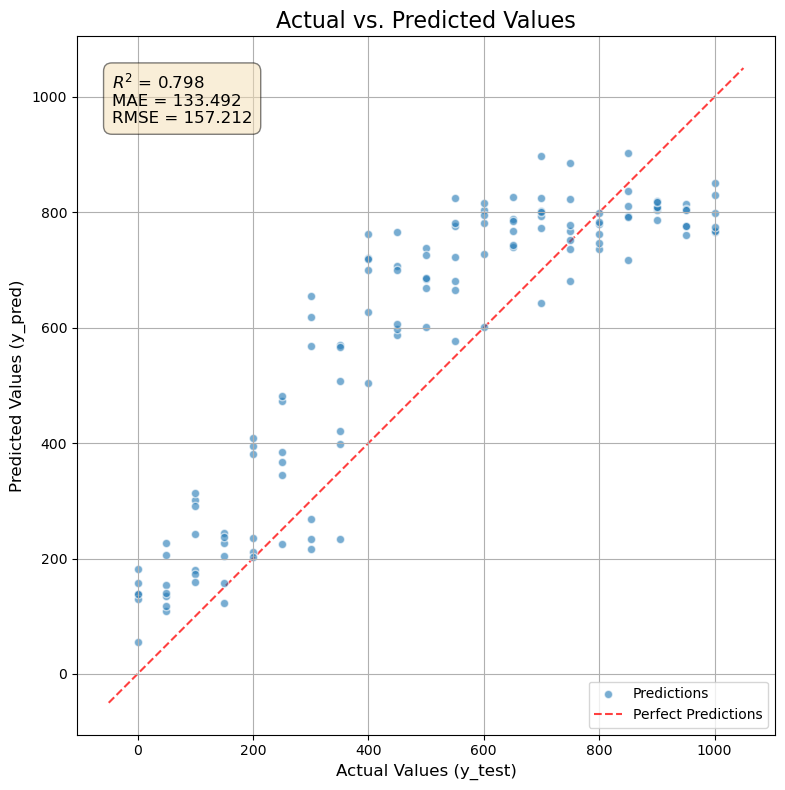

In [7]:
# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R2R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/G2.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/11-18-2025_G3_R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/11-18-2025_G3_R3.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

#print(len(X_test), len(y_test), len(X_test[0]))

X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

trained_model = model_predict(dynamic_filename,X_test_scaled,y_test)

### Second R

66 66 100
Loading model from: model_loss-55.4564_20251202-205945.keras
Model loaded successfully.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[8.02945   7.730988  7.7951665]
7.851868 0.12827384
(LOD): 8.2367 ppm
(LOQ): 9.1346 ppm
--- Residual Analysis ---
Slope: 1.0007
Residual Std Dev: 92.8114
(LOD): 306.0620 ppm
(LOQ): 927.4605 ppm
Mean Absolute Error (MAE): 103.695
Root Mean Squared Error (RMSE): 133.447
R-squared (R2): 0.922


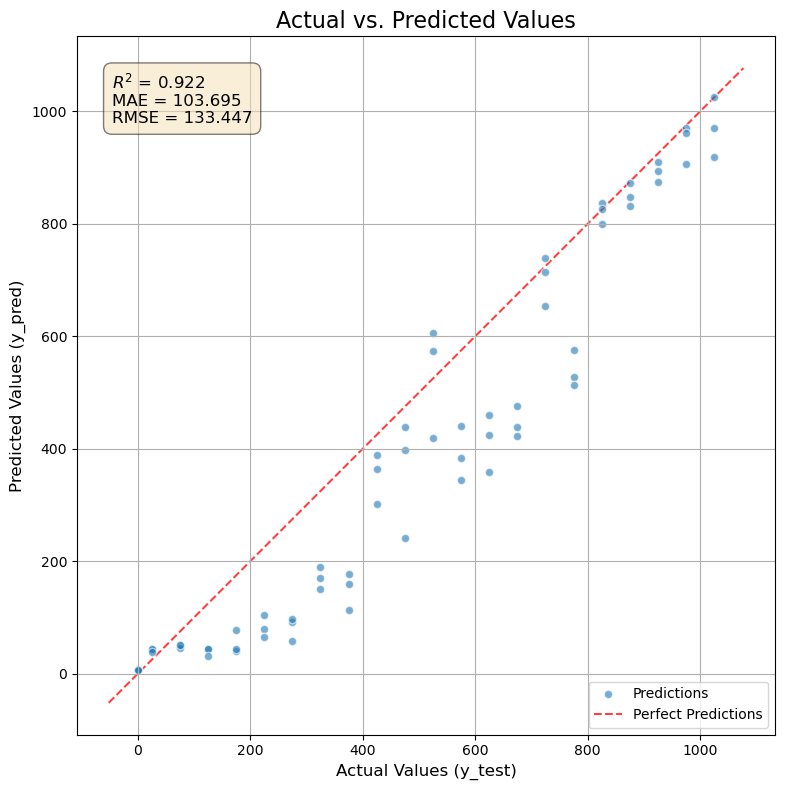

<Sequential name=sequential, built=True>

In [7]:
# File path with measurements 
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/10-26-2025_G2_R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/11-18-2025_G3_R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/10-26-2025_G2_R3.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/11-28-2025_G4_R2.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

model_predict(dynamic_filename,X_test_scaled,y_test)


### Third R

121 121 100
Loading model from: model_loss-55.4222_20251202-200200.keras
Model loaded successfully.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[ 13.234336  10.487999 145.60097    9.941377 196.13745   49.402023
  27.076122  15.930804 123.99584 ]
65.75632 66.6174
(LOD): 265.6085 ppm
(LOQ): 731.9303 ppm
--- Residual Analysis ---
Slope: 0.7629
Residual Std Dev: 108.1176
(LOD): 467.6436 ppm
(LOQ): 1417.1018 ppm
Mean Absolute Error (MAE): 100.484
Root Mean Squared Error (RMSE): 131.743
R-squared (R2): 0.913


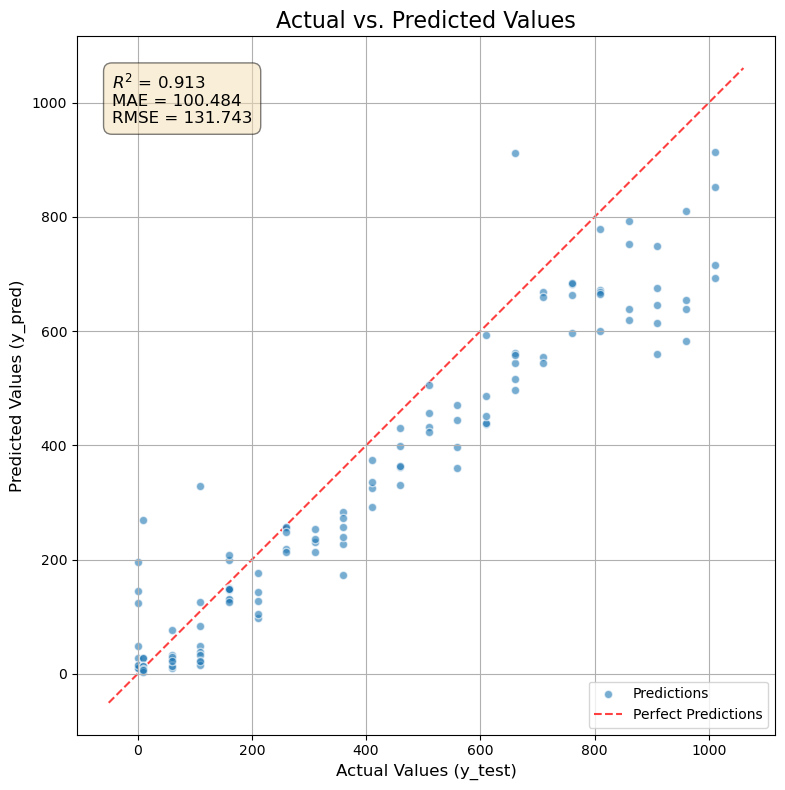

<Sequential name=sequential, built=True>

In [7]:
# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/11-29-2025_G4_R3.csv'

# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))
X_test_scaled = scaler.transform(X_test)  # Note: just .transform(), not .fit_transform()

model_predict(dynamic_filename,X_test_scaled,y_test)

In [ ]:
#!pip install everywhereml==0.2.12 #0.2.1

In [ ]:
# --- IMPORTS ---
# 1. Use the lowercase 'tf_porter' you found earlier
from everywhereml.code_generators.tensorflow import tf_porter 
# 2. CORRECTED PATH for the Scikit-learn porter
from everywhereml.sklearn import Porter 

# --- PART 1: Convert the Scaler ---
print("Converting Scaler...")
# We convert the scaler using the RAW training data (X_train)
# Note: Ensure X_train is a numpy array. 
scaler_porter = Porter(scaler, X_train, y_train) 
scaler_cpp_code = scaler_porter.to_cpp(instance_name='scaler')

with open('Use_Scaler.h', 'w') as f:
    f.write(scaler_cpp_code)
print("Saved 'Use_Scaler.h' successfully.")

# --- PART 2: Convert the TensorFlow Model ---
print("Converting Neural Network...")

# We pass 'X_train_scaled' because the model expects scaled inputs
porter = tf_porter(model, X_train_scaled, y_train)

# arena_size: 20000 is a safe starting point for ESP32
nn_cpp_code = porter.to_cpp(instance_name='gly_model', arena_size=20000)

with open('Use_Model.h', 'w') as f:
    f.write(nn_cpp_code)
print("Saved 'Use_Model.h' successfully.")

In [11]:
import numpy as np
# 1. Import specifically for the Neural Network
from everywhereml.code_generators.tensorflow import tf_porter 

# --- PART 1: Manual Generation of RobustScaler C++ Code ---
# Since everywhereml 0.2.12 struggles with the Scaler import, 
# we extract the values (Center/Median and Scale/IQR) directly.

print("Extracting Scaler parameters...")

# Check if the scaler was fitted
if not hasattr(scaler, 'center_') or not hasattr(scaler, 'scale_'):
    raise ValueError("The scaler has not been fitted yet! Run scaler.fit(X_train) first.")

# Create the C++ header content manually
# We iterate over the arrays to format them as C++ arrays
centers_str = ", ".join(map(str, scaler.center_))
scales_str = ", ".join(map(str, scaler.scale_))
num_features = len(scaler.center_)

scaler_h_content = f"""
#ifndef SCOUT_SCALER_H
#define SCOUT_SCALER_H

// RobustScaler Data
// Features: {num_features}

static const float SCALER_CENTER[{num_features}] = {{ {centers_str} }};
static const float SCALER_SCALE[{num_features}]  = {{ {scales_str} }};

/**
 * Applies RobustScaler transformation in-place or to a new buffer.
 * input: array of raw values
 * output: array where scaled values will be stored
 */
void apply_scaler(float *input, float *output) {{
    for (int i = 0; i < {num_features}; i++) {{
        output[i] = (input[i] - SCALER_CENTER[i]) / SCALER_SCALE[i];
    }}
}}

#endif
"""

with open('Use_Scaler.h', 'w') as f:
    f.write(scaler_h_content)
print("Saved 'Use_Scaler.h' (Manual generation).")


# --- PART 2: Convert the TensorFlow Model (Using everywhereml) ---
print("Converting Neural Network...")

# Important: Ensure you pass the SCALED data so the converter knows the range
# If you get an error here, make sure 'tf_porter' is the one you found earlier.
porter = tf_porter(trained_model, X_train_scaled, y_train)

# Generate C++ code
# arena_size: 20000 bytes (Increase if ESP32 crashes)
nn_cpp_code = porter.to_cpp(instance_name='gly_model', arena_size=20000)

with open('Use_Model.h', 'w') as f:
    f.write(nn_cpp_code)
print("Saved 'Use_Model.h' successfully.")

Extracting Scaler parameters...
Saved 'Use_Scaler.h' (Manual generation).
Converting Neural Network...
INFO:tensorflow:Assets written to: /var/folders/hd/994qssns5v71gyv5knr53vy00000gn/T/tmp8s6qg5bz/assets


INFO:tensorflow:Assets written to: /var/folders/hd/994qssns5v71gyv5knr53vy00000gn/T/tmp8s6qg5bz/assets


Saved artifact at '/var/folders/hd/994qssns5v71gyv5knr53vy00000gn/T/tmp8s6qg5bz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  4580609104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969898064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969896528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969898256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969898832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969897488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969899216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5969899024: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1764366495.189935  467592 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764366495.190361  467592 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-11-28 15:48:15.191004: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/hd/994qssns5v71gyv5knr53vy00000gn/T/tmp8s6qg5bz
2025-11-28 15:48:15.191387: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-28 15:48:15.191391: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/hd/994qssns5v71gyv5knr53vy00000gn/T/tmp8s6qg5bz
I0000 00:00:1764366495.194122  467592 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-11-28 15:48:15.194553: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-28 15:48:15.217837: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

Saved 'Use_Model.h' successfully.
